# **Практика 3: Атака Carlini-Wagner (CW) на модели**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Панков Евгений Ромуальдович**ИИ

##**Цель задания:**
Изучить одну из наиболее мощных атак на модели ИИ — атаку `Carlini-Wagner` (`CW`). Задача —
научиться использовать `CW` для создания противоречивых примеров и исследовать влияние этой
атаки на обученные модели.

##**Задачи:**
1. Загрузить ранее обученную модель на датасете `MNIST`;
2. Изучить теоретические основы атаки `Carlini-Wagner`;
3. Реализовать атаку `CW` с помощью фреймворка `Foolbox`;
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.

##**Шаги выполнения:**

###**Шаг 1: Загрузка обученной модели и данных `MNIST`**

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9715 - loss: 0.0998
Test accuracy on clean images: 0.9754999876022339


###**Шаг 2: Теория Carlini-Wagner Attack**

**Атака `Carlini-Wagner` (`CW`)**— это одна из наиболее эффективных атак, созданных для введения
моделей в заблуждение. В отличие от `FGSM`, `CW` использует оптимизационный подход для создания минимальных изменений в изображении, которые приводят к ошибке в классификации модели.

**Цель атаки**     — найти минимальные изменения в изображении, которые переводят его в другую
категорию, оставаясь при этом визуально неотличимыми от оригинала.

Атака `CW` может быть настроена по нескольким параметрам, например, для минимизации `L2`, `L0` или `L∞ норм`, что определяет, как именно модифицируется изображение

###**Шаг 3: Установка Foolbox и запуск CW-атаки**

Для реализации атаки `Carlini-Wagner` будем использовать фреймворк `Foolbox`, который
предоставляет удобные методы для выполнения различных атак на модели ИИ.

In [21]:
!pip install foolbox

Реализация атаки `Carlini-Wagner`:

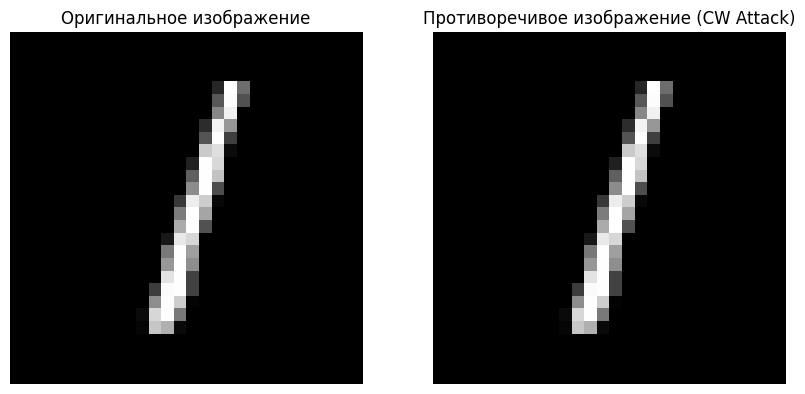

In [23]:
import foolbox as fb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Инициализация Foolbox модели:
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора):
# Добавляем размерность для батча:
image = tf.convert_to_tensor(test_images[2], dtype=tf.float32)[None, ...]
# Получаем индекс класса:
label = np.argmax(test_labels[0])
# Преобразуем в тензор:
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Создание атаки Carlini-Wagner:
attack = fb.attacks.L2CarliniWagnerAttack(steps=5)
# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов:
plt.figure(figsize=(30, 30))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

###**Шаг 4: Оценка модели на противоречивых примерах**

После того, как мы сгенерировали противоречивые примеры, мы можем оценить, насколько атака
 `Carlini-Wagner` влияет на производительность модели.

In [27]:
import torch

# Установите количество обрабатываемых изображений:
adversarial_images = []
num_images = min(1000, len(test_images))

# Обработка изображений:
for i in range(num_images):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой:
adversarial_images = tf.concat(adversarial_images, axis=0)

# Убедитесь, что test_labels имеют соответствующее количество меток:
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:num_images])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0919 - loss: 2.4004
Accuracy on adversarial examples (CW attack): 0.08299999684095383


###**Шаг 5: Сравнение результатов**

**Вывод :**

Точность модели на атакованных изображениях резко упала почти до нуля (особенно в сравнении с ее точностью на оригинальных данных), что указывает на её неспособность устойчиво классифицировать изображения в условиях целенаправленных, хоть и небольших, искажений.

**Причины падения точности модели на атакованных изображениях:**
1. Природа атак: Атаки, такие как атака Карлини-Уагнера (`Carlini-Wagner Attack`), специально разработаны для создания противоречивых примеров, которые вводят модель в заблуждение. Эти атаки минимизируют изменения, чтобы сделать их незаметными для человека, но достаточно сильными, чтобы сбить с толку модель. Поэтому модель может не распознавать атакованные изображения, что приводит к низкой точности.
2. Сложность модели: Модели глубокого обучения часто обладают высокой чувствительностью к небольшим изменениям во входных данных. Даже незначительные искажения могут значительно повлиять на предсказания, особенно если модель не была обучена на таких примерах.
3. Отсутствие устойчивости: Многие модели не обладают устойчивостью к атакам, если они не были специально обучены на противоречивых примерах. Если модель была обучена только на чистых данных, она может плохо справляться с атаками.